# MNIST VAE

Slightly modified from variational_autoencoder_deconv.py in the Keras examples folder:

**https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py**

Here, we use 3 latent dimensions instead of 2

In [1]:
WEIGHTS_FILEPATH = 'mnist_vae.hdf5'
MODEL_ARCH_FILEPATH = 'mnist_vae.json'

In [2]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Convolution2D, Deconvolution2D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
nb_filters = 128
# convolution kernel size
nb_conv = 3

batch_size = 200
original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 256
epsilon_std = 0.01

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Convolution2D(img_chns, 2, 2, border_mode='same', activation='relu', dim_ordering='tf')(x)
conv_2 = Convolution2D(nb_filters, 2, 2,
                       border_mode='same', activation='relu', dim_ordering='tf',
                       subsample=(2, 2))(conv_1)
conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu', dim_ordering='tf',
                       subsample=(1, 1))(conv_2)
conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu', dim_ordering='tf',
                       subsample=(1, 1))(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

output_shape = (batch_size, 14, 14, nb_filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu', dim_ordering='tf')
decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu', dim_ordering='tf')
output_shape = (batch_size, 29, 29, nb_filters)
decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2,
                                          output_shape,
                                          border_mode='valid',
                                          subsample=(2, 2),
                                          activation='relu', dim_ordering='tf')
decoder_mean_squash = Convolution2D(img_chns, 2, 2,
                                    border_mode='valid',
                                    activation='sigmoid', dim_ordering='tf')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='adam', loss=vae_loss)

In [4]:
nb_epoch = 100

# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        shuffle=True, nb_epoch=nb_epoch, batch_size=batch_size, verbose=2,
        callbacks=[early_stopping])

x_train.shape: (60000, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
21s - loss: 205.7691 - val_loss: 167.3319
Epoch 2/100
20s - loss: 157.5196 - val_loss: 152.4185
Epoch 3/100
20s - loss: 150.5493 - val_loss: 148.4986
Epoch 4/100
20s - loss: 146.7644 - val_loss: 145.6578
Epoch 5/100
20s - loss: 143.8765 - val_loss: 143.0071
Epoch 6/100
20s - loss: 141.8927 - val_loss: 140.6844
Epoch 7/100
20s - loss: 140.0229 - val_loss: 140.5146
Epoch 8/100
20s - loss: 138.6799 - val_loss: 138.5408
Epoch 9/100
20s - loss: 137.4184 - val_loss: 137.4149
Epoch 10/100
20s - loss: 136.3336 - val_loss: 136.7805
Epoch 11/100
20s - loss: 135.5484 - val_loss: 136.4492
Epoch 12/100
20s - loss: 134.9640 - val_loss: 136.4200
Epoch 13/100
20s - loss: 134.3523 - val_loss: 135.4650
Epoch 14/100
20s - loss: 133.5899 - val_loss: 135.4087
Epoch 15/100
20s - loss: 133.0637 - val_loss: 134.9101
Epoch 16/100
20s - loss: 132.5738 - val_loss: 134.7949
Epoch 17/100
20s - loss: 132.2521 - val_loss:

In [5]:
%matplotlib inline

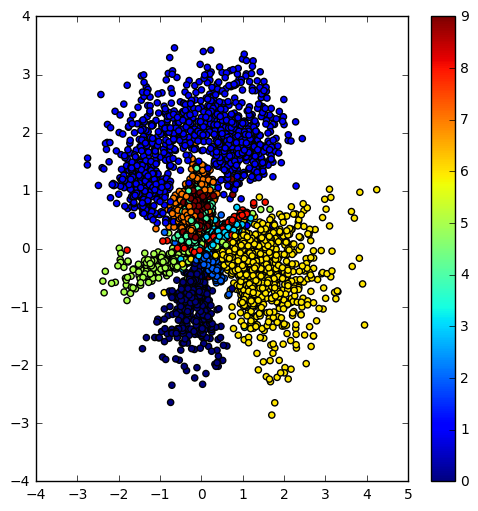

In [6]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

**Decoder generator**

To make the decoder generator serializable, we will redefine new layers and transfer weights over, rather than sharing the layers. Sharing layers will create new nodes, some with different output shapes, which causes problems for serialization.

Here we also set batch_size to 1

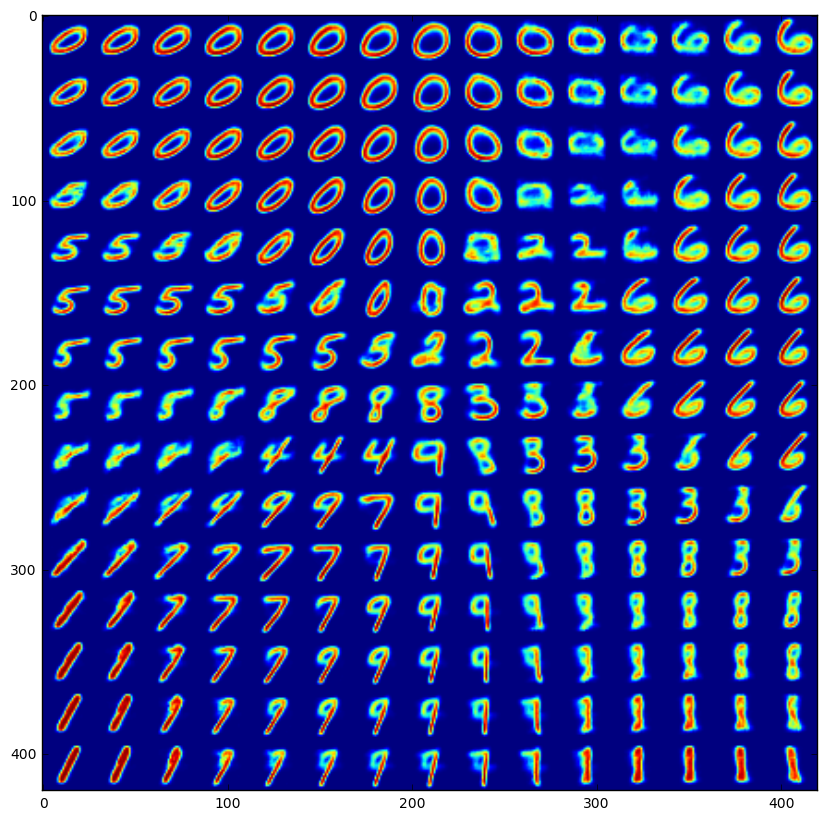

In [16]:
batch_size = 1

_hid_decoded = Dense(intermediate_dim, activation='relu')
_up_decoded = Dense(nb_filters * 14 * 14, activation='relu')
_reshape_decoded = Reshape((14, 14, nb_filters))
_deconv_1_decoded = Deconvolution2D(nb_filters, nb_conv, nb_conv, (batch_size, 14, 14, nb_filters),
                                    border_mode='same', subsample=(1, 1), activation='relu', dim_ordering='tf')
_deconv_2_decoded = Deconvolution2D(nb_filters, nb_conv, nb_conv, (batch_size, 14, 14, nb_filters),
                                    border_mode='same', subsample=(1, 1), activation='relu', dim_ordering='tf')
_x_decoded_relu = Deconvolution2D(nb_filters, 2, 2, (batch_size, 29, 29, nb_filters),
                                  border_mode='valid', subsample=(2, 2), activation='relu', dim_ordering='tf')
_x_decoded_mean_squash = Convolution2D(img_chns, 2, 2, border_mode='valid', activation='sigmoid', dim_ordering='tf')

decoder_input = Input(shape=(latent_dim,))
layer1 = _hid_decoded(decoder_input)
layer2 = _up_decoded(layer1)
layer3 = _reshape_decoded(layer2)
layer4 = _deconv_1_decoded(layer3)
layer5 = _deconv_2_decoded(layer4)
layer6 = _x_decoded_relu(layer5)
layer7 = _x_decoded_mean_squash(layer6)
generator = Model(decoder_input, layer7)

_hid_decoded.set_weights(decoder_hid.get_weights())
_up_decoded.set_weights(decoder_upsample.get_weights())
_deconv_1_decoded.set_weights(decoder_deconv_1.get_weights())
_deconv_2_decoded.set_weights(decoder_deconv_2.get_weights())
_x_decoded_relu.set_weights(decoder_deconv_3_upsamp.get_weights())
_x_decoded_mean_squash.set_weights(decoder_mean_squash.get_weights())

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-1, 1] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [17]:
generator.save_weights(WEIGHTS_FILEPATH)

with open(MODEL_ARCH_FILEPATH, 'w') as f:
    f.write(generator.to_json())